In [1]:
#%pip install ipywidgets
#%pip install voila
#%pip install voila-gridstack
### 

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import pandas.util.testing as tm
import statsmodels.api as sm
import seaborn as sns
import statsmodels.formula.api as smf
import ipywidgets as wdg
from IPython.display import display
from ipywidgets import GridspecLayout

In [3]:
### input data
## data filename
datafilename1 = 'sepsis_survival_primary.csv'
datafilename2 = 'sepsis_survival_study.csv'
datafilename3 = 'sepsis_survival_validation.csv'

## depended Variable column name
dependVar = 'hospital_outcome_1alive_0dead'
## exclude columns from analyze (text, urls, etc. )
excludeColumns = []
## minimum correlation coeff to assume as a key variable
minimumCorrCoef = 0.01
threshold = 0.5


In [4]:
## read CSV file, autodetect delimeters, skip spaces in names
df1 = pd.read_csv(datafilename1, sep=None, engine="python", skipinitialspace=True)
df2 = pd.read_csv(datafilename2, sep=None, engine="python", skipinitialspace=True)
df3 = pd.read_csv(datafilename3, sep=None, engine="python", skipinitialspace=True)
dfs = [df1, df2, df3]
df1.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1


In [23]:
for df in dfs:
    ## exclude columns
    df.drop(excludeColumns, axis ='columns', inplace = True)
    ## and drop  all NaN
    df.dropna(inplace=True)
    ## place depended var into pos 0
    poped = df.pop(dependVar)
    df.insert(0, poped.name, poped)
        
## independed variable columns names  
independVarList = list(df.columns.values)
independVarList.remove(dependVar)

In [ ]:
class LogisticRegression:
    def __init__(self, dfTrain, dfTest):
        self.dfTrain = dfTrain.copy()
        self.dfTest = dfTest.copy()
        self.models = []
        self.modresults = []
        self.predictVars = []
        ### make models for all variables and combinations
        self.allResults = pd.DataFrame(columns=['vars', 'passprob', 'res', 'model', 'BA', 'TP', 'FN', 'TN', 'FP'])
        CalculateModels()
        
    def CalculateModels(self):
        keyVars = GetKeyVariables(self.dfTrain)
        self.dependVar = keyVars['key'].iloc[0]
        ### All vars into list.
        self.predictVars = keyVars['key'].iloc[1:NvarsCount+1].to_list()
        ### make models for all variables, sequently adding one by one
        for n,indvar in enumerate(self.predictVars):
            indvars = self.predictVars[:n+1]
            modvars = list(map(lambda orig_string: 'Q("' + orig_string + '")', indvars))
            model = smf.logit(formula = '' + dependVar + ' ~ ' + ' + '.join(modvars), data = dfTrain)
            res = model.fit(disp=False)
            self.models.append(model)
            self.modresults.append(res)


    def GetKeyVariables(self, df):
        parCorr = pd.DataFrame(df.corr() )
        n = len(parCorr.columns)
        keyVars = pd.DataFrame(columns=['key', 'val'])
        ## depended variable moved to index 0
        i = 0
        for j in range( n):
            if j >= i:
                keyVars = keyVars.append({'key':parCorr.columns[j],'val':parCorr.iloc[i, j]}, ignore_index=True)
        ## sort key vars by value
        keyVars.pop(df.columns[0])
        keyVars.sort_values(by='val', key=abs, ascending=False, inplace=True)
        return keyVars

    
    def get_BA(self, crossdf):
        crossdf.index = crossdf.index.map(str)
        crossdf.columns = crossdf.columns.map(str)
        try: TN = crossdf.loc['0','0']
        except: TN = 0
        try: FN = crossdf.loc['0','1']
        except: FN = 0
        try: FP = crossdf.loc['1','0']
        except: FP = 0
        try: TP = crossdf.loc['1','1']
        except: TP = 0
        ###print('tn=', TN, 'fn=', FN, 'fp=', FP, 'tp=', TP)
        try: TPR = TP/(TP + FN)
        except: TPR = np.NaN
        try: TNR = TN/(TN + FP)
        except: TNR = np.NaN
        BA = (TPR + TNR)/2
        return dict(zip(['BA', 'TN', 'FN', 'TP', 'FP'], [BA, TN, FN, TP, FP]))
        pass
    
    
    def TestModels(self):
        ### calculate BA for all threashholds...
        passProbabilities = np.linspace(0,1,int(1/0.05)+1)

        ## Generate all possible combinations of variables
        variableList = sum([list(map(list, itertools.combinations(self.predictVars, i))) for i in range(len(self.predictVars) + 1)], [])
        variableList = list(filter(None, variableList))

        for n,indvars in enumerate(variableList):
            ## progress # display(indvars)
            modvars = list(map(lambda orig_string: 'Q("' + orig_string + '")', indvars))
            model = smf.logit(formula = '' + dependVar + ' ~ ' + ' + '.join(modvars), data = self.dfTrain )
            fitresult = model.fit(disp=False)
            for prob in passProbabilities:
                inSample = pd.DataFrame({'probability':fitresult.predict(self.dfTest[indvars])}) 
                inSample['Model prediction'] = (inSample['probability'] >= prob).astype(int) ## 0 or 1 values based on probabilities
                confMatrix = pd.crosstab(inSample['Model prediction'], self.dfTest[self.dependVar], dropna=False)
                ba = get_BA(confMatrix)
                ### add all info to one dataframe
                ## TODO: memory consumption?
                self.allResults = self.allResults.append({'vars':indvars, 
                                   'passprob':prob, 
                                   'res':fitresult, 
                                   'model':model, **(ba)},
                                 ignore_index=True)        




In [24]:
allVars=dfclean.columns
####WORK ON THIS ONE!!!!!
##PUT widgets horizontally
nxdr = wdg.Dropdown(options = allVars, value = allVars[1], 
                    description = 'X value', option = 'X var')

nBinsdr = wdg.Dropdown(options=[2,10,15,20,40], value=2, 
                    description = 'Bins number', option = 'Bin value')

def plot_histogram(x = 'age_years', nBins = 15, PlotKDE = False):    
    sns.histplot(data = dfclean[x] , bins = nBins, kde = PlotKDE)

out = wdg.interact(plot_histogram, nBins = nBinsdr,PlotKDE = False,x=nxdr)
ui = wdg.HBox([nxdr,nBinsdr])

interactive(children=(Dropdown(description='X value', index=1, options=('hospital_outcome_1alive_0dead', 'age_…

In [7]:
dftrain = dfclean.sample(frac=0.8, random_state = 200) #training data set (80%)
dftest = dfclean.drop(dftrain.index) #testing data set (20%)

In [8]:
allVars=dfclean.columns
####WORK ON THIS ONE!!!!!
##PUT widgets horizontally
nxdr2x = wdg.Dropdown(options = allVars, value = allVars[1], 
                    description = 'X value', option = 'X var')
nxdr2y = wdg.Dropdown(options = allVars, value = allVars[1], 
                    description = 'X value', option = 'X var')

def plot_scatterplot(x = 'age_years', y = 'hospital_outcome_1alive_0dead'):    
    sns.scatterplot(data = dfclean , x = x, y = y)

out2 = wdg.interact(plot_scatterplot, x=nxdr2x, y = nxdr2y)
ui = wdg.HBox([nxdr2x,nxdr2y])


interactive(children=(Dropdown(description='X value', index=1, options=('hospital_outcome_1alive_0dead', 'age_…

## Regular regressional analise through all possible variables

In [9]:
def HeatmapCorr(df): 
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.set_theme(style="white")
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Custom colormap
    cmap = sns.diverging_palette(275, 150, s=90, l=50, n=9, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap,  linewidths=0.3, cbar_kws={"shrink":0.5})

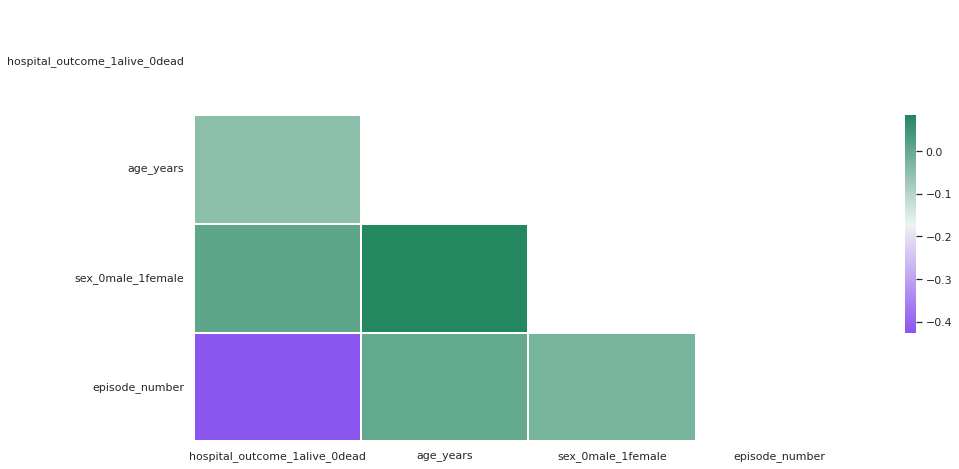

In [10]:
HeatmapCorr(df3)

In [11]:
def GetKeyVariables(df):
    parCorr = pd.DataFrame(df.corr() )
    n = len(parCorr.columns)
    keyVars = pd.DataFrame(columns=['key', 'val'])
    ## depended variable moved to index 0
    i = 0
    for j in range( n):
        if j >= i:
            keyVars = keyVars.append({'key':parCorr.columns[j],'val':parCorr.iloc[i, j]}, ignore_index=True)
    ## sort key vars by value
    keyVars.pop(df.columns[0])
    keyVars.sort_values(by='val', key=abs, ascending=False, inplace=True)
    return keyVars

#display(GetKeyVariables(dftrain[[dependVar, *set1]]))
#display(GetKeyVariables(dftrain[[dependVar, *set2]]))
#display(GetKeyVariables(dftrain[[dependVar, *set3]]))
#display(GetKeyVariables(dftrain[[dependVar, *set4]]))
#display(GetKeyVariables(dftrain[[dependVar, *set5]]))
#display(GetKeyVariables(dftrain))


In [12]:
#for1 = dftrain.columns[4]+'~'+dftrain.columns[4]

In [13]:
#mod = smf.ols(formula=for1, data = dftrain)
#res = mod.fit()
#res.summary()

In [14]:

def LogRegModel(independVarList):
    indepVars = ''
    for i in range(0,len(independVarList)-1):
        indepVars+=independVarList[i]
        indepVars+=" + "
    indepVars+=independVarList[-1]
    depVar = dependVar
    model = smf.logit(formula = depVar+' ~ '+ indepVars,data = dftrain)
    res = model.fit()
    print(depVar,'~',indepVars,':',
              round(res.prsquared,5))#McFadden's pseudo-R-squared.
    """
    inSample = pd.DataFrame({'prob':res.predict(dftest[independVarList])}) #probabilities 
    inSample['predLabel'] = (inSample['prob'] > threshold).astype(int) #labels based on probabilities
    inSample.head()
    confMatrix = pd.crosstab(inSample['predLabel'],dftest[depVar])
    #sns.heatmap(confMatrix, annot = True)                  
    #plt.show()
    #calculation of BA 
    BA=0
    TN = confMatrix.loc[0,0]
    FN = confMatrix.loc[0,1]
    FP = confMatrix.loc[1,0]
    TP = confMatrix.loc[1,1]
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    BA = (TPR + TNR)/2
    print(f'BA = {BA:0.4f}')
    """
def LogRegModelSqrt(independVarList):
    indepVars = ''
    for i in range(0,len(independVarList)-1):
        indepVars+='np.power('+independVarList[i]+',2)'
        indepVars+=" + "
    indepVars+='np.power('+independVarList[-1]+',2)'
    depVar = dependVar
    model = smf.logit(formula = depVar+' ~ '+ indepVars,data = dftrain)
    res = model.fit()
    print(depVar,'~',indepVars,':',
              round(res.prsquared,5))#McFadden's pseudo-R-squared.

In [15]:
#LogRegModel(independVarList)
#LogRegModel(independVarList[0:1])
#LogRegModel(independVarList[1:2])
#LogRegModel(independVarList[2:3])

In [16]:
#LogRegModelSqrt(independVarList)
#LogRegModelSqrt(independVarList[0:1])
#LogRegModelSqrt(independVarList[1:2])
#LogRegModelSqrt(independVarList[2:3])

In [17]:
df_scaled = (dftrain - dftrain.min())/(dftrain.max() - dftrain.min())

In [18]:
x = dftrain[["age_years","sex_0male_1female","episode_number"]]
y = dftrain["hospital_outcome_1alive_0dead"]

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def optimize(x, y,learning_rate,iterations,parameters): 
    size = x.shape[0]
    weight = parameters["weight"] 
    bias = parameters["bias"]
    for i in range(iterations): 
        sigma = sigmoid(np.dot(x, weight) + bias)
        loss = -1/size * np.sum(y * np.log(sigma)) + (1 - y) * np.log(1 - sigma)
        dW = 1/size * np.dot(x.T, (sigma - y)) 
        db = 1/size * np.sum(sigma - y)
        weight -= learning_rate * dW
        bias -= learning_rate * db 
    
    parameters["weight"] = weight
    parameters["bias"] = bias
    return parameters
# Initialize the weight and bias
init_parameters = {} 
init_parameters["weight"] = np.zeros(x.shape[1])
init_parameters["bias"] = 0

def train(x, y, learning_rate,iterations):
    parameters_out = optimize(x, y, learning_rate, iterations ,init_parameters)
    return parameters_out
# Train the model
parameters_out = train(x, y, learning_rate = 0.02, iterations = 500)
parameters_out


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


{'weight': array([ 0.05251083,  0.12424849, -0.44082973]),
 'bias': 0.06038909748790655}

In [19]:
#Predict
#print(len(df3))
df3_scaled = (df3 - dftrain.min())/(dftrain.max() - dftrain.min())
 #- df3.min())/(df3.max() - df3.min())
x = df3_scaled[["age_years","sex_0male_1female","episode_number"]]
y = df3_scaled["hospital_outcome_1alive_0dead"]
output_vals = np.dot(x,parameters_out["weight"]) + parameters_out["bias"]
predictions = sigmoid(output_vals) >= 1/2
#print(len(predictions))

In [20]:
#np.array(df['hospital_outcome_1alive_0dead'])

In [21]:
countT=0
countF=0
for i in np.array(predictions==np.array(df3_scaled['hospital_outcome_1alive_0dead'])):
    if i ==True:
        countT += 1
    elif i== False: 
        countF +=1
print(countF,countT, "Prediction accuracy:", countT/(countT+countF))

22 115 Prediction accuracy: 0.8394160583941606


In [22]:
i,j = 4,4
grid = GridspecLayout(i,j)
dfval = dftrain[["age_years","sex_0male_1female","episode_number"]] 
#print(dfval.min())
def create_expanded_button(description, button_style):
    return wdg.Button(description=description, button_style=button_style,
                      layout=wdg.Layout(height='auto', width='auto'))


grid[2, 0] = create_expanded_button('Send'.format(0, 0), 'warning')
grid[2, 1] = create_expanded_button('Clear'.format(0, 0), 'warning')
btn_sex = grid[0,0] = wdg.Dropdown(description='Sex', options =['Female','Male'])
btn_age = grid[0,1] = wdg.Dropdown(description='Age', options =range(26,100))
btn_episodes = grid[0,2] = wdg.Dropdown(description='Episodes number', options =range(1,5))

btn_outcome = grid[1,0] = wdg.Text(value='.......', description='Outcome')

def evaluate():
    Alist = 0
    print('Sex:',btn_sex.value,
          ', Age:',btn_age.value,
          ', Episode Number',btn_episodes.value)
    sex_value = 1
    if btn_sex.value == 'Female':
        sex_value = 1
    else:
        sex_value = 0
    
    Alist = np.array([btn_age.value,sex_value,btn_episodes.value])
    print(Alist)
  
    Alist_scaled = (Alist - dfval.min())/(dfval.max() - dfval.min())   
    print(Alist_scaled)
    x = Alist_scaled
    output_vals = np.dot(x,parameters_out["weight"]) + parameters_out["bias"]
    predictions = sigmoid(output_vals) >= 1/2
    if predictions == True:
         btn_outcome.value = 'ALIVE'
    elif predictions ==False:
        btn_outcome.value = 'DEAD'
    
def clear():
    print('clear')
        

def on_btn_click(btn):
    if btn.description == 'Send':
        evaluate()
    elif btn.description == 'Clear':
        clear()

for j in range(2):
    grid[2,j].on_click(on_btn_click)

grid

GridspecLayout(children=(Button(button_style='warning', description='Send', layout=Layout(grid_area='widget001…